# Customer Service Chatbot Application

In [ ]:
!pip install gradio -q
!pip install typing_extensions

In [ ]:
! spacy download da_core_news_md --quiet

2023-12-06 11:09:04.965608: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 11:09:04.965760: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 11:09:04.965961: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 11:09:07.028815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 11.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('da_core_news_md')


## Import liberaries and conversation file

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

# utils...
import json
import requests
import random
import time

import spacy #spacy for quick language prepro
nlp = spacy.load('da_core_news_md') #instantiating Danish module

from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline, make_pipeline
 #pipeline creation
from sklearn.feature_extraction.text import TfidfVectorizer #transforms text to sparse matrix
from sklearn.linear_model import LogisticRegression #Logit model

# For controlling warnings in the code
import warnings
from sklearn.exceptions import ConvergenceWarning

In [ ]:
# We will call the below code to ignore all selected warnings in the code for getting more clearn outputs
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

A JSON file, like "convo.json," can be useful for organizing conversation flows, storing responses, or defining rules for a customer service chatbot. It's a structured way to manage dialogue trees, intents, entities, and responses within a chatbot framework. However, whether you specifically need a file named "convo.json" depends on the framework or platform you're using to build your chatbot.

Many chatbot development platforms or frameworks offer their own ways to structure conversations, sometimes using JSON or similar formats. These files help maintain and organize the chatbot's knowledge base, making it easier to update and manage conversations.

If you're developing a chatbot from scratch or using a platform that requires such a file, creating a "convo.json" or a similar structured file for your customer service chatbot could be beneficial. It allows you to define the chatbot's responses, conversation paths, and logic in a clear, organized manner.

In [ ]:
# stream file from remote online
r = requests.get('https://raw.githubusercontent.com/tobiasmj97/M3_Semester_Project/main/convo_snt_chatbot.json')
json_data = json.loads(r.text)

# Data description and understanding

In [ ]:
json_data

{'intents': [{'tag': 'hilsen',
   'patterns': ['Hej', 'Halløj', 'Goddag', 'God dag'],
   'responses': ['Hej 😊',
    'Hej, hvad kan jeg hjælpe med?',
    'Hej, hvordan kan jeg hjælpe?']},
  {'tag': 'svar',
   'patterns': ['Går det godt?'],
   'responses': ['Det går godt. Hvad med dig?']},
  {'tag': 'farvel',
   'patterns': ['Farvel', 'Vi ses senere', 'Farvel'],
   'responses': ['Vi ses senere, tak for besøget',
    'Hav en god dag',
    'Farvel! Kom tilbage snart.']},
  {'tag': 'tak',
   'patterns': ['Tak', 'Tak skal du have', 'Tak for hjælpen', 'Mange tak!'],
   'responses': ['Glad for at kunne hjælpe!',
    'Altid klar til at hjælpe!',
    'Det var en fornøjelse']},
  {'tag': 'Bestilling i butik',
   'patterns': ['Jeg vil gerne bestille en vare til hjemmelevering',
    'Kan jeg bestille produkter til levering?',
    'Hvordan bestiller jeg varer til levering?',
    'Hvordan bestiller jeg produkter fra butikken?',
    'Bestilling af vare til hjemmelevering'],
   'responses': ['Når du ha

In [ ]:
# Reformating data and reformatting into useable data
data_1 = []

for i in json_data['intents']:
  l = len(i['patterns'])
  tuples = list(zip(i['patterns'], l*[i['tag']]))
  data_1.extend(tuples)

In [ ]:
# Created a pandas DataFrame from our data
df = pd.DataFrame(data_1, columns=['txt','label'])
df.head(15)

,txt,label
0,Hej,hilsen
1,Halløj,hilsen
2,Goddag,hilsen
3,God dag,hilsen
4,Går det godt?,svar
5,Farvel,farvel
6,Vi ses senere,farvel
7,Farvel,farvel
8,Tak,tak
9,Tak skal du have,tak


In [ ]:
# Including response for EDA purposes
data_2 = []

for i in json_data['intents']:
  l = len(i['patterns'])
  k = len(i['responses'])
  tuples = list(zip(i['patterns'], i['responses'], l*[i['tag']]))
  data_2.extend(tuples)

In [ ]:
df_EDA = pd.DataFrame(data_2, columns=['txt','response','label'])
df_EDA.head(15)

,txt,response,label
0,Hej,Hej 😊,hilsen
1,Halløj,"Hej, hvad kan jeg hjælpe med?",hilsen
2,Goddag,"Hej, hvordan kan jeg hjælpe?",hilsen
3,Går det godt?,Det går godt. Hvad med dig?,svar
4,Farvel,"Vi ses senere, tak for besøget",farvel
5,Vi ses senere,Hav en god dag,farvel
6,Farvel,Farvel! Kom tilbage snart.,farvel
7,Tak,Glad for at kunne hjælpe!,tak
8,Tak skal du have,Altid klar til at hjælpe!,tak
9,Tak for hjælpen,Det var en fornøjelse,tak


# Exploratory data analysis / EDA

## Overview of data / Description of the data

In [ ]:
# How many questions do we have?
df['txt'].count()

167

In [ ]:
df.shape

(167, 2)

In [ ]:
# Count number of unique labels
df["label"].nunique()

46

In [ ]:
# Value counts for each labels
df["label"].value_counts()

Sådan indtaster du din rabatkode eller dit gavekort             6
Bestilling i butik                                              5
reklamation                                                     5
Refundering                                                     5
moms                                                            5
hilsen                                                          4
Ordrenummer ved returnering                                     4
Told- og importgebyr                                            4
Ombytning eller returnering af gave købt i butik                4
Returnering af produkter fra forskellige ordrer                 4
Hvornår modtager jeg min refundering?                           4
Returnering fra fysisk butik til online                         4
Hvor kan man købe produkter fra Shaping New Tomorrow?           4
Levering i weekenden                                            4
Betaling med Klarna                                             4
Erhverv   

In [ ]:
# Count number of unique response
df_EDA["response"].nunique()

52

In [ ]:
# Statistics for the sentences
print("Minimum sentence length: ", df['txt'].str.len().min())
print("Maximum  sentence length: ", df['txt'].str.len().max())
print("Average sentence length: ", df['txt'].str.len().mean())
print("Median sentence length: ", df['txt'].str.len().median())
print("Mode: ", df['txt'].str.len().mode())

Minimum sentence length:  3
Maximum  sentence length:  65
Average sentence length:  32.32335329341317
Median sentence length:  31.0
Mode:  0    29
Name: txt, dtype: int64


## EDA on pattern attribute

Text(0.5, 1.0, 'Character length of sentence')

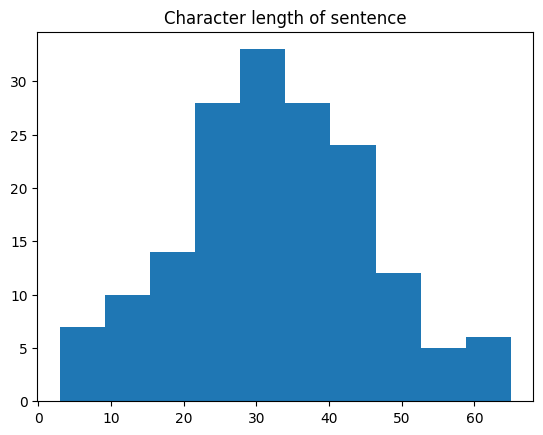

In [ ]:
# Making a histogram for the question and the length of the question
df['txt'].str.len().hist()
plt.grid(False)
plt.title('Character length of sentence')

Text(0.5, 1.0, 'Character length of response')

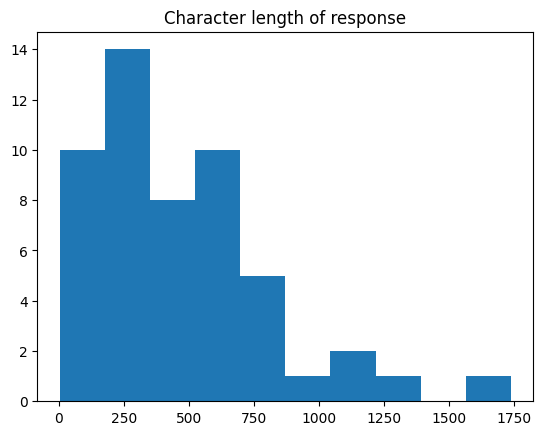

In [ ]:
# making a histogram for the response lengths
df_EDA['response'].str.len().hist()
plt.grid(False)
plt.title('Character length of response')

In [ ]:
# making a function for average word length in each sentence
def plot_word_length_histogram(text):
    text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x)).\
        hist()
    plt.grid(False)

Text(0.5, 1.0, 'Average word length in questions')

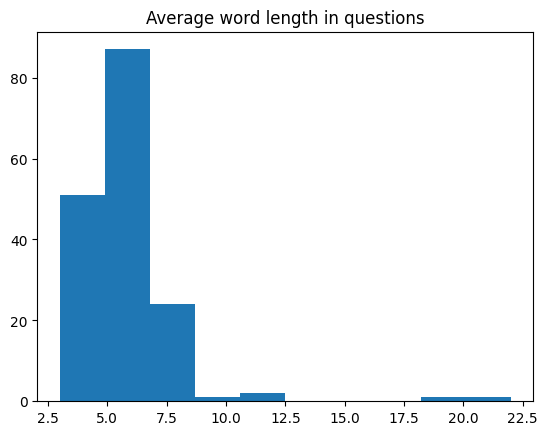

In [ ]:
# average word length in each questions sentence
plot_word_length_histogram(df['txt'])
plt.title('Average word length in questions')

Text(0.5, 1.0, 'Average word length in response')

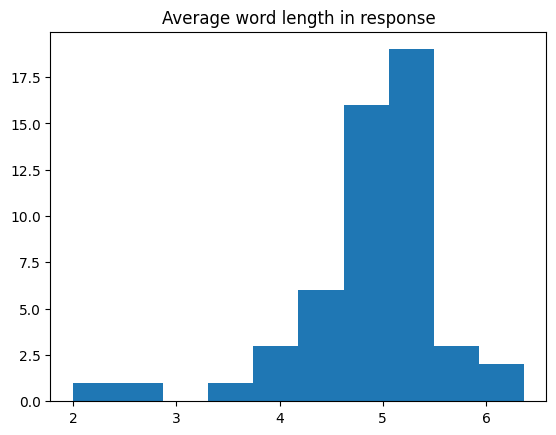

In [ ]:
# average word length in each response sentence
plot_word_length_histogram(df_EDA['response'])
plt.title('Average word length in response')

### Make additional attributes

In [ ]:
# Length of questions
df['Length_txt'] = df['txt'].str.len()

In [ ]:
# count of words for questions
def word_count(review):
    review_list = review.split()
    return len(review_list)

df['Word_count'] = df['txt'].apply(word_count)

In [ ]:
# mean word length for each question
df['mean_word_length'] = df['txt'].map(lambda rev: np.mean([len(word) for word in rev.split()]))

In [ ]:
# import nltk for tokenize the sentences
from nltk import tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# mean sentence length using nltk
df['mean_sent_length'] = df['txt'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))

In [ ]:
df.head()

,txt,label,Length_txt,Word_count,mean_word_length,mean_sent_length
0,Hej,hilsen,3,1,3.000000,3.0
1,Halløj,hilsen,6,1,6.000000,6.0
2,Goddag,hilsen,6,1,6.000000,6.0
3,God dag,hilsen,7,2,3.000000,7.0
4,Går det godt?,svar,13,3,3.666667,13.0


In [ ]:
# Statistics for the sentences
print("Minimum word count: ", df['Word_count'].min())
print("Maximum  word count: ", df['Word_count'].max())
print("Average word count: ", df['Word_count'].mean())
print("Median word count: ", df['Word_count'].median())
print("Mode: ", df['Word_count'].mode())

Minimum word count:  1
Maximum  word count:  12
Average word count:  5.2155688622754495
Median word count:  5.0
Mode:  0    5
Name: Word_count, dtype: int64


Text(0.5, 1.0, 'Word Count Histogram')

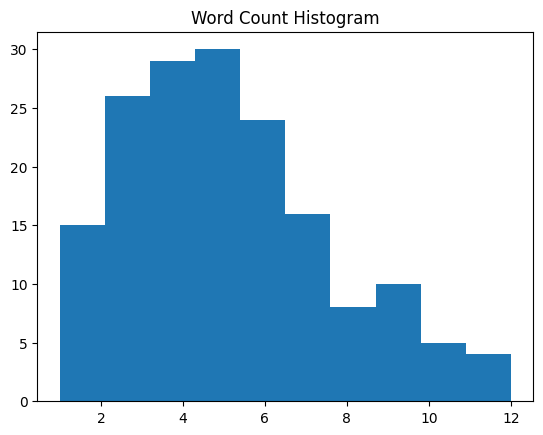

In [ ]:
# make a historgram for word count
df['Word_count'].hist()
plt.grid(False)
plt.title('Word Count Histogram')

Text(0.5, 1.0, 'Boxplot of Word Count and text length')

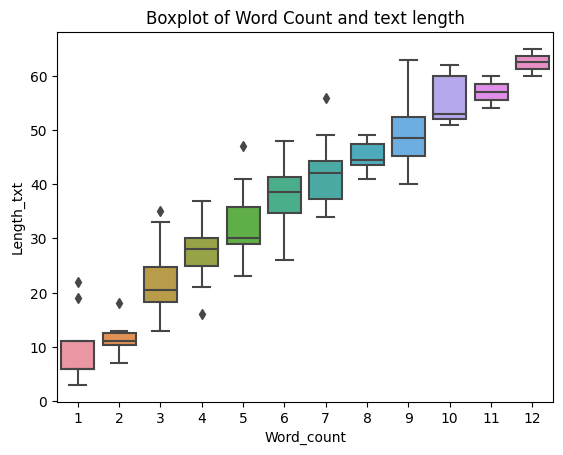

In [ ]:
# box plot for word count and length of questions
sns.boxplot(data=df, x="Word_count", y="Length_txt")
plt.title('Boxplot of Word Count and text length')

## EDA on stop words and most frequent words

In [ ]:
def plot_top_stopwords_barchart(text):
    stopwords = list(nlp.Defaults.stop_words)

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stopwords:
            dic[word]+=1

    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.title('Top 10 stopwords barchart')
    plt.bar(x,y)

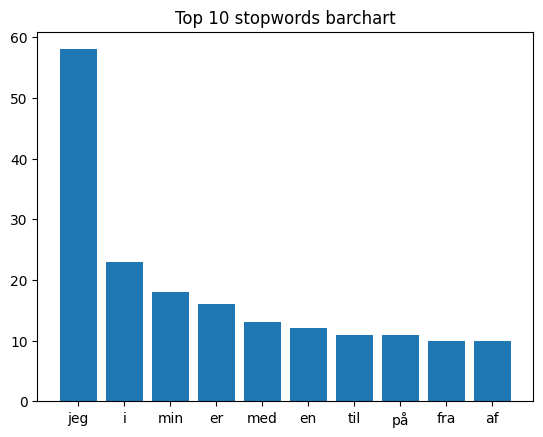

In [ ]:
plot_top_stopwords_barchart(df['txt'])

In [ ]:
def get_top_stopwords(text):
    stopwords = list(nlp.Defaults.stop_words)

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    from collections import defaultdict
    dic = defaultdict(int)
    for word in corpus:
        if word in stopwords:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
    return top

In [ ]:
get_top_stopwords(df['txt'])

[('jeg', 58),
 ('i', 23),
 ('min', 18),
 ('er', 16),
 ('med', 13),
 ('en', 12),
 ('til', 11),
 ('på', 11),
 ('fra', 10),
 ('af', 10)]

In [ ]:
from collections import  Counter

In [ ]:
def plot_top_non_stopwords_barchart(text):
    stopwords = list(nlp.Defaults.stop_words)

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stopwords):
            x.append(word)
            y.append(count)

    plt.title('Top non stopwords barchart')
    sns.barplot(x=y,y=x)

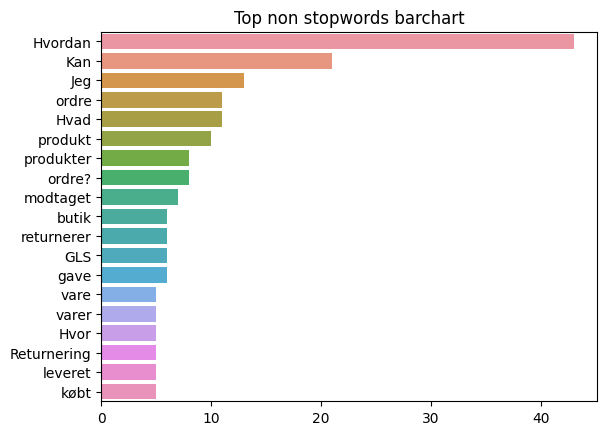

In [ ]:
plot_top_non_stopwords_barchart(df['txt'])

In [ ]:
def get_top_non_stopwords(text):
    stopwords = list(nlp.Defaults.stop_words)

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()

    top_non_stopwords = [(word, count) for word, count in most if word not in stopwords][:10]
    return top_non_stopwords

In [ ]:
get_top_non_stopwords(df['txt'])

[('Hvordan', 43),
 ('Kan', 21),
 ('Jeg', 13),
 ('ordre', 11),
 ('Hvad', 11),
 ('produkt', 10),
 ('produkter', 8),
 ('ordre?', 8),
 ('modtaget', 7),
 ('butik', 6)]

# Data cleaning and preparation

## Text Preprocessing

In [ ]:
def text_prepro(texts):
  """
  takes in a list/iterable of texts
  lowercases, normalizes text
  """

  clean_container = []

  for text in nlp.pipe(texts, disable=["parser", "ner"]):

    txt = [token.lemma_.lower() for token in text # lemmatize and lower
          if token.is_alpha # remove numbers
          and not token.is_punct] # remove punctoation

    clean_container.append(" ".join(txt))

  return clean_container

# Model building

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# new df.txt_p
df.txt_p = text_prepro(df.txt)

# Divide data between training and test data
X = df.txt_p
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

## Model testing


### Multinomial LogisticRegression

In [ ]:
# make pipeline for LogisticRegression
textclassifier_mlg = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mlg', LogisticRegression( multi_class='multinomial', # Set algorithm to multinomial since this is a multi class problem
                                random_state=0, # Set the seed for the algorithm to make sure there is consistency across multiple runs
                                warm_start = True, # To make the model converge faster
                                l1_ratio = 0.5)) # Set to the elastic net regularization
])

In [ ]:
# Hyperparameters to tune
params = {'mlg__penalty': ['l1', 'l2', 'elasticnet', 'none' ],
          'mlg__C': [0.01, 0.1, 0.3, 0.5, 1.0,],
          'mlg__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'] # List of compatible solver for multi_class = multinomial
         }

In [ ]:
# definition of GridSearch for hyperparameter tuning
multinomial_lg_grid = GridSearchCV(estimator=textclassifier_mlg, param_grid=params)

In [ ]:
# fit the model
multinomial_lg_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mlg',
                                        LogisticRegression(l1_ratio=0.5,
                                                           multi_class='multinomial',
                                                           random_state=0,
                                                           warm_start=True))]),
             param_grid={'mlg__C': [0.01, 0.1, 0.3, 0.5, 1.0],
                         'mlg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'mlg__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']})

In [ ]:
# evaluation
print('Train Accuracy : %.3f'%multinomial_lg_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%multinomial_lg_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%multinomial_lg_grid.best_score_)
print('Best Parameters : ',multinomial_lg_grid.best_params_)

Train Accuracy : 1.000
Test Accuracy : 0.529
Best Accuracy Through Grid Search : 0.654
Best Parameters :  {'mlg__C': 0.01, 'mlg__penalty': 'none', 'mlg__solver': 'lbfgs'}


In [ ]:
# defining y_pred
y_pred = multinomial_lg_grid.predict(X_test)

In [ ]:
print("confusion_matrix")
print(confusion_matrix(y_test,y_pred))

confusion_matrix
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 

In [ ]:
print("classification_report")
print(classification_report(y_test,y_pred))

classification_report
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.00      0.00      0.00         0
                                        Annullering af ordre       0.00      0.00      0.00         0
                                          Bestilling i butik       1.00      0.33      0.50         3
                                         Betalingsmuligheder       0.00      0.00      0.00         1
                                     Defekt produkt modtaget       0.00      0.00      0.00         0
                                                     Erhverv       1.00      1.00      1.00         1
                                                    Gavekort       0.00      0.00      0.00         1
                       Hvornår modtager jeg min refundering?       0.00      0.00      0.00         0
Kan jeg få besked, når en udsolgt vare kommer på lager igen

In [ ]:
print("accuracy_score")
print(accuracy_score(y_test, y_pred))

accuracy_score
0.5294117647058824


### SVM

In [ ]:
# make pipeline for svm
textclassifier_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', svm.SVC(probability = True))
])

In [ ]:
# Hyperparameters to tune
params = {'svm__decision_function_shape': ['ovo', 'ovr'],
          'svm__C': [0.01, 0.1, 0.3, 0.5, 1.0,]
}

In [ ]:
# definition of GridSearch for hyperparameter tuning
svm_grid = GridSearchCV(estimator=textclassifier_svm, param_grid=params)

In [ ]:
# fit the model
svm_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': [0.01, 0.1, 0.3, 0.5, 1.0],
                         'svm__decision_function_shape': ['ovo', 'ovr']})

In [ ]:
# evaluate
print('Train Accuracy : %.3f'%svm_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%svm_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%svm_grid.best_score_)
print('Best Parameters : ',svm_grid.best_params_)

Train Accuracy : 0.985
Test Accuracy : 0.176
Best Accuracy Through Grid Search : 0.390
Best Parameters :  {'svm__C': 1.0, 'svm__decision_function_shape': 'ovo'}


In [ ]:
# defining y_pred
y_pred = svm_grid.predict(X_test)

In [ ]:
print("confusion_matrix")
print(confusion_matrix(y_test,y_pred))

confusion_matrix
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 

In [ ]:
print("classification_report")
print(classification_report(y_test,y_pred))

classification_report
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.00      0.00      0.00         0
                                        Annullering af ordre       0.00      0.00      0.00         0
                                          Bestilling i butik       0.00      0.00      0.00         3
                                         Betaling med Klarna       0.00      0.00      0.00         0
                                         Betalingsmuligheder       0.00      0.00      0.00         1
                                                     Erhverv       1.00      1.00      1.00         1
                                                    Gavekort       0.00      0.00      0.00         1
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       1.00      1.00      1.00         1
                                        Levering i weekende

In [ ]:
print("accuracy_score")
print(accuracy_score(y_test, y_pred))

accuracy_score
0.17647058823529413


### RANDOM FORESTS

In [ ]:
# make pipeline for RandomForestClassifier
textclassifier_rn = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=0))
])

In [ ]:
# Hyperparameters to tune
params = {
    'rf__n_estimators': [0, 10, 20],            # Number of trees in the forest
    'rf__max_depth': [None, 10, 20],               # Maximum depth of the tree
    'rf__min_samples_split': [2, 5, 10],           # Minimum number of samples required to split an internal node
    'rf__min_samples_leaf': [1, 2, 4]              # Minimum number of samples required to be at a leaf node
}

In [ ]:
# definition of GridSearch for hyperparameter tuning
rf_grid = GridSearchCV(estimator=textclassifier_rn, param_grid=params)

In [ ]:
# fit the model
rf_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=0))]),
             param_grid={'rf__max_depth': [None, 10, 20],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [0, 10, 20]})

In [ ]:
# evaluate
print('Train Accuracy : %.3f'%rf_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%rf_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%rf_grid.best_score_)
print('Best Parameters : ',rf_grid.best_params_)

Train Accuracy : 0.940
Test Accuracy : 0.382
Best Accuracy Through Grid Search : 0.466
Best Parameters :  {'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 20}


In [ ]:
# defining y_pred
y_pred = rf_grid.predict(X_test)

In [ ]:
print("confusion_matrix")
print(confusion_matrix(y_test,y_pred))

confusion_matrix
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0

In [ ]:
print("classification_report")
print(classification_report(y_test,y_pred))

classification_report
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.00      0.00      0.00         0
                                        Annullering af ordre       0.00      0.00      0.00         0
                                          Bestilling i butik       1.00      0.67      0.80         3
                                         Betalingsmuligheder       0.00      0.00      0.00         1
                                                     Erhverv       1.00      1.00      1.00         1
                                                    Gavekort       0.00      0.00      0.00         1
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       1.00      1.00      1.00         1
                                        Levering i weekenden       1.00      1.00      1.00         1
                                         Leveringsmulighede

In [ ]:
print("accuracy_score")
print(accuracy_score(y_test, y_pred))

accuracy_score
0.38235294117647056


### KNN

In [ ]:
# make pipeline for KNeighborsClassifier
textclassifier_knn = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [ ]:
# Hyperparameters to tune
params = {'knn__n_neighbors': [5,6,7,8,9,10],
          'knn__weights': ['uniform', 'distance'],
          'knn__p': [1, 2, 3]
          }

In [ ]:
# definition of GridSearch for hyperparameter tuning
knn_grid = GridSearchCV(estimator=textclassifier_knn, param_grid=params)

In [ ]:
# fit the model
knn_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [5, 6, 7, 8, 9, 10],
                         'knn__p': [1, 2, 3],
                         'knn__weights': ['uniform', 'distance']})

In [ ]:
# evaluate
print('Train Accuracy : %.3f'%knn_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%knn_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%knn_grid.best_score_)
print('Best Parameters : ',knn_grid.best_params_)

Train Accuracy : 1.000
Test Accuracy : 0.500
Best Accuracy Through Grid Search : 0.511
Best Parameters :  {'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'distance'}


In [ ]:
# defining y_pred
y_pred = knn_grid.predict(X_test)

In [ ]:
print("confusion_matrix")
print(confusion_matrix(y_test,y_pred))

confusion_matrix
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 

In [ ]:
print("classification_report")
print(classification_report(y_test,y_pred))

classification_report
                                                              precision    recall  f1-score   support

                                        Annullering af ordre       0.00      0.00      0.00         0
                                          Bestilling i butik       1.00      1.00      1.00         3
                                         Betaling med Klarna       0.00      0.00      0.00         0
                                         Betalingsmuligheder       0.00      0.00      0.00         1
                                                     Erhverv       1.00      1.00      1.00         1
                                                    Gavekort       0.00      0.00      0.00         1
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       1.00      1.00      1.00         1
                                        Levering i weekenden       1.00      1.00      1.00         1
                                         Leveringsmulighede

In [ ]:
print("accuracy_score")
print(accuracy_score(y_test, y_pred))

accuracy_score
0.5


### Multinomial Naive Bayes

In [ ]:
# make pipeline for MultinomialNB
textclassifier_mnb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [ ]:
# Hyperparameters to tune
params = {'mnb__alpha': [0.01, 0.1, 0.3, 0.5, 1.0]}

In [ ]:
# definition of GridSearch for hyperparameter tuning
multinomial_nb_grid = GridSearchCV(estimator=textclassifier_mnb, param_grid=params)

In [ ]:
# fit the model
multinomial_nb_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'mnb__alpha': [0.01, 0.1, 0.3, 0.5, 1.0]})

In [ ]:
# evaluate
print('Train Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_grid.best_score_)
print('Best Parameters : ',multinomial_nb_grid.best_params_)

Train Accuracy : 0.992
Test Accuracy : 0.559
Best Accuracy Through Grid Search : 0.571
Best Parameters :  {'mnb__alpha': 0.01}


In [ ]:
# defining y_pred
y_pred = multinomial_nb_grid.predict(X_test)

In [ ]:
print("confusion_matrix")
print(confusion_matrix(y_test,y_pred))

confusion_matrix
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 

In [ ]:
print("classification_report")
print(classification_report(y_test,y_pred))

classification_report
                                                              precision    recall  f1-score   support

                                        Annullering af ordre       0.00      0.00      0.00         0
                                          Bestilling i butik       1.00      1.00      1.00         3
                                         Betaling med Klarna       0.00      0.00      0.00         0
                                         Betalingsmuligheder       0.00      0.00      0.00         1
                                                     Erhverv       0.50      1.00      0.67         1
                                    Forkert produkt modtaget       0.00      0.00      0.00         0
                                                    Gavekort       0.00      0.00      0.00         1
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       1.00      1.00      1.00         1
                                        Levering i weekende

In [ ]:
print("accuracy_score")
print(accuracy_score(y_test, y_pred))

accuracy_score
0.5588235294117647


### Decision Tree

In [ ]:
# make pipeline for DecisionTreeClassifier
textclassifier_dt = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier())
])

In [ ]:
# Hyperparameters to tune
params = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [None, 5, 10, 15, 20],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__max_features': ['auto', 'sqrt', 'log2', None],
    'dt__random_state': [42]
}

In [ ]:
# definition of GridSearch for hyperparameter tuning
dt_grid = GridSearchCV(estimator=textclassifier_dt, param_grid=params)

In [ ]:
# fit the model
dt_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('dt', DecisionTreeClassifier())]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': [None, 5, 10, 15, 20],
                         'dt__max_features': ['auto', 'sqrt', 'log2', None],
                         'dt__min_samples_leaf': [1, 2, 4],
                         'dt__min_samples_split': [2, 5, 10],
                         'dt__random_state': [42]})

In [ ]:
# evaluate
print('Train Accuracy : %.3f'%dt_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%dt_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%dt_grid.best_score_)
print('Best Parameters : ',dt_grid.best_params_)

Train Accuracy : 1.000
Test Accuracy : 0.294
Best Accuracy Through Grid Search : 0.428
Best Parameters :  {'dt__criterion': 'gini', 'dt__max_depth': None, 'dt__max_features': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2, 'dt__random_state': 42}


In [ ]:
# defining y_pred
y_pred = dt_grid.predict(X_test)

In [ ]:
print("confusion_matrix")
print(confusion_matrix(y_test,y_pred))

confusion_matrix
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 

In [ ]:
print("classification_report")
print(classification_report(y_test,y_pred))

classification_report
                                                              precision    recall  f1-score   support

                                          Afhentning i butik       0.00      0.00      0.00         0
                                          Bestilling i butik       0.00      0.00      0.00         3
                                         Betalingsmuligheder       0.00      0.00      0.00         1
                                                     Erhverv       1.00      1.00      1.00         1
                                                    Gavekort       0.00      0.00      0.00         1
Kan jeg få besked, når en udsolgt vare kommer på lager igen?       0.00      0.00      0.00         1
                                        Levering i weekenden       1.00      1.00      1.00         1
                                         Leveringsmuligheder       0.00      0.00      0.00         1
                           Leveringsmuligheder - DHL Expres

In [ ]:
print("accuracy_score")
print(accuracy_score(y_test, y_pred))

accuracy_score
0.29411764705882354


## Model loading

### LogisticRegression

In [ ]:
#instantiate models and "bundle up as pipeline"

tfidf = TfidfVectorizer()
cls = LogisticRegression()

pipe = make_pipeline(tfidf, cls)
pipe.fit(df.txt_p, df.label)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [ ]:
pipe.predict(['Hvordan indtaster jeg rabatkode?'])

array(['Sådan indtaster du din rabatkode eller dit gavekort'],
      dtype=object)

In [ ]:
bot_name = '💬 SNT Bot'

In [ ]:
def reply(txt):
  clean_text = text_prepro([txt])
  tag = pipe.predict(clean_text)[0]
  for intent in json_data['intents']:
    if tag == intent["tag"]:
      return f"{bot_name}: {random.choice(intent['responses'])}"

In [ ]:
reply('Hvordan bruger jeg en rabatkode?')

"💬 SNT Bot: Rabatkoder og gavekort indtastes i samme felt. Følg de få trin herunder for at finde feltet:\n\n1. Når du har valgt det ønskede produkt, trykker du på indkøbskurven øverst i højre hjørne\n2. Acceptér så handelsbetingelserne og tryk 'Gå til betaling'\n3. Herefter kommer du til siden 'Oplysninger', hvor du skal klikke på 'Vis ordreoversigt'\n4. Du kan nu indtaste dit gavekort eller din rabatkode i feltet\n\nHvis du er i besiddelse af et fysisk gavekort i form af et kreditkort, kan du bruge dette online og i de danske butikker ved at indtaste cifrene undtagen de første fem.\n\nBemærk venligst: Det ikke er muligt at tilføje en rabatkode til en ordre, hvis man bestiller noget, der i forvejen er nedsat (sæt- eller kvantumrabat)."

In [ ]:
reply('Kan jeg passe bukserne hvis jeg har store lår?')

'💬 SNT Bot: Hvis du har store lår eller lægge plejer det, som udgangspunkt, ikke at være noget problem. Vi tilbyder nemlig både Slim og Regular fit.\n\nDu kan altid prøve vores bukser på i nogle timer og derefter bestemme dig for, om du synes, at de har givet sig tilstrækkeligt og sidder, som du ønsker det.'

### Multinomial Logistic Regression

In [ ]:
multinomial_lg_grid.predict(['Hvordan indtaster jeg rabatkode?'])

array(['Sådan indtaster du din rabatkode eller dit gavekort'],
      dtype=object)

In [ ]:
def reply_mlg(txt):
  clean_text = text_prepro([txt])
  tag = multinomial_lg_grid.predict(clean_text)[0]
  for intent in json_data['intents']:
    if tag == intent["tag"]:
      return f"{bot_name}: {random.choice(intent['responses'])}"

In [ ]:
reply_mlg('Hvordan bruger jeg en rabatkode?')

"💬 SNT Bot: Rabatkoder og gavekort indtastes i samme felt. Følg de få trin herunder for at finde feltet:\n\n1. Når du har valgt det ønskede produkt, trykker du på indkøbskurven øverst i højre hjørne\n2. Acceptér så handelsbetingelserne og tryk 'Gå til betaling'\n3. Herefter kommer du til siden 'Oplysninger', hvor du skal klikke på 'Vis ordreoversigt'\n4. Du kan nu indtaste dit gavekort eller din rabatkode i feltet\n\nHvis du er i besiddelse af et fysisk gavekort i form af et kreditkort, kan du bruge dette online og i de danske butikker ved at indtaste cifrene undtagen de første fem.\n\nBemærk venligst: Det ikke er muligt at tilføje en rabatkode til en ordre, hvis man bestiller noget, der i forvejen er nedsat (sæt- eller kvantumrabat)."

In [ ]:
reply_mlg('Hvordan benytter jeg en rabatkode?')

"💬 SNT Bot: Rabatkoder og gavekort indtastes i samme felt. Følg de få trin herunder for at finde feltet:\n\n1. Når du har valgt det ønskede produkt, trykker du på indkøbskurven øverst i højre hjørne\n2. Acceptér så handelsbetingelserne og tryk 'Gå til betaling'\n3. Herefter kommer du til siden 'Oplysninger', hvor du skal klikke på 'Vis ordreoversigt'\n4. Du kan nu indtaste dit gavekort eller din rabatkode i feltet\n\nHvis du er i besiddelse af et fysisk gavekort i form af et kreditkort, kan du bruge dette online og i de danske butikker ved at indtaste cifrene undtagen de første fem.\n\nBemærk venligst: Det ikke er muligt at tilføje en rabatkode til en ordre, hvis man bestiller noget, der i forvejen er nedsat (sæt- eller kvantumrabat)."

In [ ]:
reply_mlg('Kan man købe som erhverv?')

'💬 SNT Bot: Til alle vores butikker har vi tilknyttet en skrædder, som gør det muligt for dig at få lavet ændringer på dine SNT produkter. Dette er muligt at benytte sig af både ved køb i vores fysiske butikker, men også ved online køb, hvis du efterfølgende møder op i butikken med produktet\n\nVores skræddere tilbyder følgende ydelser:  \n\nBukser:\nOplægning: Fra 70,- DKK\nLynlås, udskiftning: Fra 100,- DKK\nBukseknap: Fra 20,- DKK\n\nBemærk, at ovenstående priser er vejledende.\n\nSkjorter:\nOplægning: Fra 100,- DKK\n\nBemærk, at ovenstående pris er vejledende.\n\nBlazer:\nOplægning: Fra 160,- DKK\nViddejustering: Fra 170,- DKK\n\nBemærk, at ovenstående priser er vejledende.\n\nPriserne for de forskellige skrædderydelser varierer fra butik til butik. Ønsker du at høre nærmere herom, skal du være velkommen til at henvende dig i vores butikker eller tage kontakt til vores kundeservice'

In [ ]:
reply('Kan man købe som erhverv?')

"💬 SNT Bot: Man kan udelukkende købe vores produkter i vores egne butikker i Danmark og Tyskland eller på vores hjemmeside http://shapingnewtomorrow.dk/\n\nTip: Der er desværre en del falske hjemmesider i omløb, der påstår at sælge Shaping New Tomorrow produkter. For at undgå ærgerlige og skuffende oplevelser kan du med fordel downloade browserudvidelsen 'Sikker shopping' til Google Chrome, som E-mærket har udviklet i samarbejde med Trygfonden.\n\n Installerer du denne app, så fortæller appen dig, hvis du er inde på en hjemmeside, der ikke er sikker og hvor du har stor sandsynlighed for enten at ende op med en kopivare eller, i værste fald, med at miste dine penge."

# Evaluation of models

# Deployment of application

In [ ]:
def reply(txt):
  clean_text = text_prepro([txt])
  tag = pipe.predict(clean_text)[0] #LogisticRegression
  for intent in json_data['intents']:
    if tag == intent["tag"]:
      return f"{bot_name}: {random.choice(intent['responses'])}"

In [ ]:
def reply_mlg(txt):
  clean_text = text_prepro([txt])
  tag = multinomial_lg_grid.predict(clean_text)[0] #MultinomialLogisticRegression
  for intent in json_data['intents']:
    if tag == intent["tag"]:
      return f"{bot_name}: {random.choice(intent['responses'])}"

## Application

In [ ]:
with gr.Blocks() as demo:
    chatbot = gr.Chatbot()
    msg = gr.Textbox()
    clear = gr.ClearButton([msg, chatbot])

    def respond(message, chat_history):
        # use the reply_da function to get the bot's message
        bot_message = reply(message)
        chat_history.append((message, bot_message))
        time.sleep(2)
        return "", chat_history

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1c2d586995d408b1a5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Topic modelling
